###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018  by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

###### Translated by Huizhe Di @ SCSIO

In [1]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.axes_grid1 import make_axes_locatable

# 粘弹性应力-应变关系

我们比较了在频域不同的粘弹性应力-应变关系来实现常 Q(ω) 的行为。

## 一维各向同性SH问题: 线弹性 vs. 粘弹性介质

为了理解线弹性和粘弹性一维SH问题的区别，我们首先回顾了一维弹性SH问题的偏微分方程。这包括动量守恒:

\begin{equation}
\rho \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial \sigma_{yx}}{\partial x} + f_y\notag
\end{equation}

描述介质内变形 $\epsilon_{yx}$ 作为给定剪应力 $\sigma_{yx}$ 的响应, 我们使用线性应力-应变关系:


\begin{equation}
\sigma_{yx} = 2\mu \epsilon_{yx}\notag
\end{equation}

通过剪切模量 $\mu$. 为了简化符号，我定义 

\begin{equation}
\mu' = 2\mu\notag
\end{equation}

和 

\begin{equation}
\mu = \mu'\notag
\end{equation}

进一步, 我代替:

\begin{align}
\sigma_{yx} &\rightarrow \sigma\notag\\
\epsilon_{yx} &\rightarrow \epsilon\notag\\
\end{align}

得到:

\begin{equation}
\sigma = \mu \epsilon\notag
\end{equation}

为了描述一个 **线性粘弹性介质**, 我们只需要修改应力应变关系，因为动量守恒与材料行为无关。粘弹性应力-应变关系可以被描述为 **玻尔兹曼叠加和因果原理**:

\begin{equation}
\sigma = \int_{-\infty}^{t}\Psi(t-t')\dot{\epsilon}(t')dt'\notag
\end{equation}

通过 **松弛函数 $\Psi$**。松弛函数和积分边界构成了因果关系。你可以看到粘弹性介质有一个包含应变率历史的“褪色”记忆。根据定义，我们可以将应力-应变关系重写为松弛函数与应变速率 $\dot{\epsilon}$ 的卷积：

\begin{equation}
\sigma = \Psi*\dot{\epsilon}\notag
\end{equation}

利用卷积时间导数的性质:

\begin{equation}
\frac{\partial}{\partial t} (\Psi*\epsilon) = \frac{\partial \Psi}{\partial t} * \epsilon = \Psi * \frac{\partial \epsilon}{\partial t}\notag
\end{equation}

我们可以把粘弹性介质的应力应变关系改写为

\begin{equation}
\sigma = \dot{\Psi}*\epsilon\notag
\end{equation}

让我们比较弹性介质和粘弹性介质的应力-应变关系，假设应力和应变谐变。 

在弹性情况下，这两个变化是一致的:

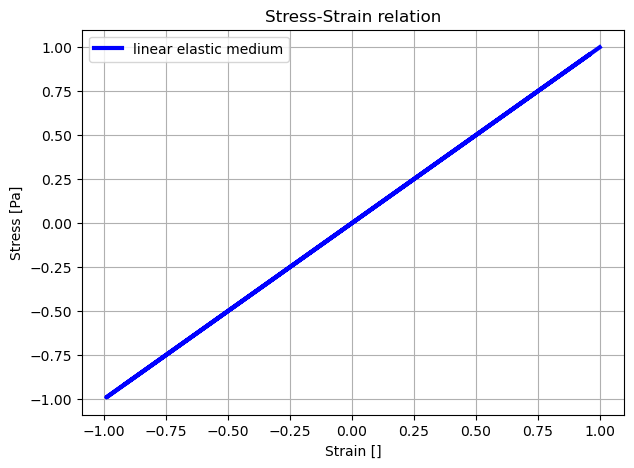

In [2]:
# Stress-stain relation for linear elastic medium
# -----------------------------------------------
t = np.arange(0.0,10.0)  # time (s)

sigma0 = 1.0             # maximum stress (Pa)
epsilon0 = 1.0           # maximum strain ()
omega = 1.0              # Circular frequency (rad/s)

# Calculate temporal changes of sigma and epsilon
# -----------------------------------------------
sigma = sigma0 * np.cos(omega*t)
epsilon = epsilon0 * np.cos(omega*t)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(epsilon, sigma, 'b-',lw=3,label="linear elastic medium")
plt.title('Stress-Strain relation')
plt.xlabel('Strain []')
plt.ylabel('Stress [Pa]')
plt.legend()
plt.grid()
plt.show()

在粘弹性的情况下，应力和应变是不相的。我们稍后会看到，相移 $\phi$ 是与品质因子 $Q$ 相关的 

\begin{equation}
\phi = \arctan{\frac{1}{Q}} \notag
\end{equation}

这就引出了粘弹性应力应变关系:

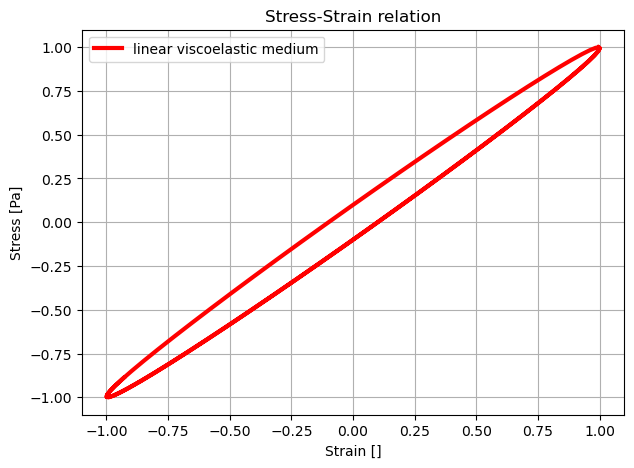

In [3]:
# Stress-stain relation for linear viscoelastic medium
# ----------------------------------------------------
t = np.arange(0.0,10.0,0.1)  # time (s)

sigma0 = 1.0             # maximum stress (Pa)
epsilon0 = 1.0           # maximum strain ()
omega = 1.0              # Circular frequency (rad/s)

# define phase shift of strain
Q = 10                     # quality factor ()
phi = np.arctan(1/Q)       # phase shift (rad)

# Calculate temporal changes of sigma and epsilon
# -----------------------------------------------
sigma = sigma0 * np.cos(omega*t)
epsilon = epsilon0 * np.cos(omega*t - phi)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(epsilon, sigma, 'r-',lw=3,label="linear viscoelastic medium") 
plt.title('Stress-Strain relation')
plt.xlabel('Strain []')
plt.ylabel('Stress [Pa]')
plt.legend()
plt.grid()
plt.show()

能量损失 $\Delta E$ ，例如热量损失, 它由 [hysteresis loop](https://en.wikipedia.org/wiki/Hysteresis)内的面积定义, 因此我们计算 $\Delta E$ 通过:

\begin{equation}
\Delta E = \oint \sigma(\epsilon') d\epsilon' \notag
\end{equation}

此外，我们还可以区分线性粘弹性的两种特殊情况:

1. 上述情况是 **不可逆(非弹性)**
2. **可逆(非弹性)** 介质在去除负载后可以恢复到原来的状态

## 粘弹性模型

到目前为止，松弛函数的细节还没有定义。因此，下一步是寻找一个 $Q(\omega)$-value 与频率无关的松弛函数。与电网络类似，我们可以构建由两个基本元素组成的粘弹性模型。

### 基本元素

这些基本元素为 

<img src="images/Hooke_Newton_model.png" width="60%">

* The **Hooke element** (spring), 表示线弹性介质

\begin{align}
\sigma_{Hooke} &= \mu \epsilon \notag\\
&\text{or} \notag\\
\epsilon_{Hooke} &= \frac{\sigma}{\mu}\notag\\
\end{align}

* The **Newton element** (dashpot), 代表用应力-应变关系表示的粘性阻尼部分: 

\begin{align}
\sigma_{Newton} &= \eta \dot{\epsilon} \notag\\
&\text{or} \notag\\
\dot{\epsilon}_{Newton} &= \frac{\sigma}{\eta}\notag\\
\end{align}

这里 $\eta$ 代表介质的粘度。

### Maxwell模型

为了实现不同的粘弹性介质，可以将不同网络中的基本元素组合起来。胡克与牛顿单元的串连得到 **麦克斯韦模型**:

<img src="images/Maxwell_model.png" width="70%">

在串行连接中，有效变形可以用基本单元变形之和来计算

\begin{equation}
\epsilon = \epsilon_1 + \epsilon_2 \notag
\end{equation}

或者通过对时间求导

\begin{equation}
\dot{\epsilon} = \dot{\epsilon}_1 + \dot{\epsilon}_2 \notag
\end{equation}

对于麦克斯韦模型，我们得到下面的常微分方程对于 $\epsilon$ 和 $\sigma$

\begin{equation}
\dot{\epsilon}_{M} = \dot{\epsilon}_{Newton} + \dot{\epsilon}_{Hooke} = \frac{\sigma}{\eta} + \frac{\dot{\sigma}}{\mu}\notag
\end{equation}

我们通过傅里叶变换解决这个问题，这里频率域中的波场定义为  

\begin{equation}
\tilde{f}(\omega) = \int_{-\infty}^{\infty} f(t) exp(-i\omega t) dt\notag
\end{equation}

对时间导数进行变换:

\begin{equation}
i \omega \tilde{f}(\omega) = \int_{-\infty}^{\infty} \dot{f}(t) exp(-i\omega t) dt\notag
\end{equation}

因此, 频率域的麦克斯韦模型为:

\begin{equation}
i \omega \tilde{\epsilon}_{M} = \frac{\tilde{\sigma}}{\eta} + \frac{i \omega \tilde{\sigma}}{\mu}\notag
\end{equation}

经过一些重新排列，我们得到了频率域的应力-应变关系

\begin{equation}
\tilde{\epsilon}_{M} = \biggl(\frac{1}{\mu}+\frac{1}{i \omega \eta}\biggr) \tilde{\sigma}\notag
\end{equation}

这里，我们可以通过复剪切模量把应变和应力联系起来 $\tilde{\mu}_M$:

\begin{equation}
\tilde{\epsilon}_{M} = \tilde{\mu_M} \tilde{\sigma}\notag
\end{equation}

和

\begin{equation}
\tilde{\mu}_M = \frac{1}{\mu}+\frac{1}{i \omega \eta}\notag
\end{equation}

对于地震模型的应用，黏弹性模型能够描述一个与频率 $Q(\omega)$ 无关的结构是很重要的。这个问题很容易回答，因为我们可以将麦克斯韦模型的复剪切模量 $\tilde{\mu}_M$ 的实部和虚部与品质因子 $Q$ 联系起来:


\begin{equation}
\frac{1}{Q} = \frac{{\frak{I}}\{\tilde{\mu}_M\}}{{\frak{R}}\{\tilde{\mu}_M\}} = \tan{\phi},\notag
\end{equation}

这也解释了为什么我们可以把相位角 $\phi$ 和 $1/Q$ 联系起来, 当我们研究上述谐波应力/应变的应力-应变关系时。因此，让我们画出 $1/Q$ 随 $\omega$ 的变化:

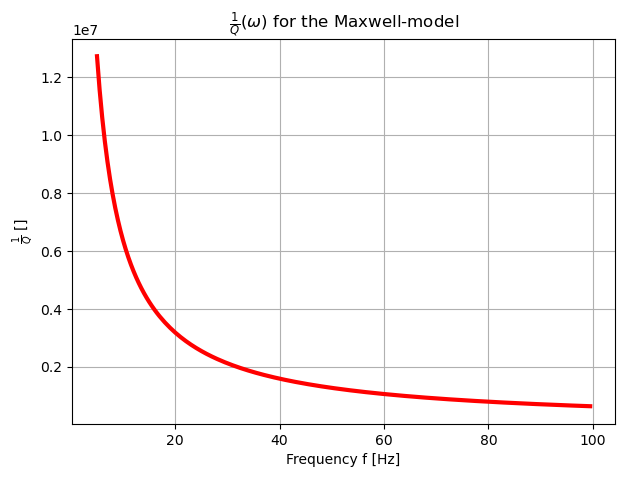

In [5]:
# 1/Q(omega) for the Maxwell-model
# --------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
eta = 1.0            # viscosity (Pa s)

# Define complex shear modulus for Maxwell-model
# ----------------------------------------------
muM = (1/mu) + (1/(1j*omega*eta))

# Calculate 1/Q(omega)
# --------------------
Qinv = np.abs(np.imag(muM)/np.real(muM))

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Maxwell-model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for the Maxwell-model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

正如你所看到的，麦克斯韦模型对粘弹性地震波传播的模型是没有用的，因为我们在高频处有很小的阻尼。

### Kelvin–Voigt模型

如果我们把Hooke和Newton连接为 **Kelvin-Voigt model**，会产生怎么样的结果?

<img src="images/Kelvin_Voigt_model.png" width="70%">

在单元并联时，有效应力可由基本单元应力之和计算

\begin{equation}
\sigma = \sigma_1 + \sigma_2 \notag
\end{equation}

对于麦克斯韦模型，我们有应力

\begin{align}
\sigma_{Hooke} &= \mu \epsilon\notag \\
\sigma_{Newton} &= \eta \dot{\epsilon}\notag \\
\end{align}

可以得到Kelvin-Voigt模型的常微分方程

\begin{equation}
\sigma_{KV} = \sigma_{Hooke} + \sigma_{Newton} = \mu \epsilon + \eta \dot{\epsilon} \notag
\end{equation}

经过傅里叶变换和一些重排我们得到

\begin{equation}
\tilde{\sigma}_{KV}(\omega) = (\mu + \eta i \omega)\; \tilde{\epsilon}(\omega) \notag
\end{equation}

这里，Kelvin-Voigt模型的复剪切模量

\begin{equation}
\tilde{\mu}_{KV} = (\mu + \eta i \omega) \notag
\end{equation}

可以确定。让我们从复Kelvin-Voigt剪切模量的实部和虚部计算 $1/Q(\omega)$ 的行为:

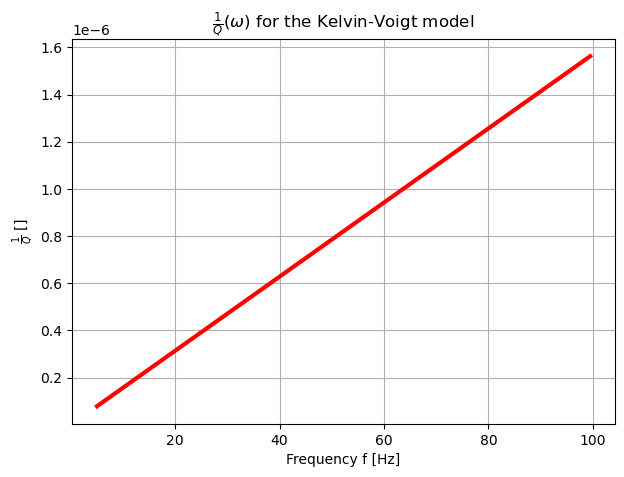

In [9]:
# 1/Q(omega) for the Kelvin-Voigt model
# -------------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
eta = 1.0            # viscosity (Pa s)

# Define complex shear modulus for Kelvin-Voigt model
# ---------------------------------------------------
muKV = mu + 1j * omega * eta

# Calculate 1/Q(omega)
# --------------------
Qinv = np.imag(muKV)/np.real(muKV)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Kelvin-Voigt model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for the Kelvin-Voigt model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

不幸的是，Kelvin-Voigt模型也不适用于粘弹性波的传播，因为阻尼随频率线性增加。


### 标准线性固体(SLS) - Maxwell

构建粘弹性模型的另一种方法是将麦克斯韦单元与胡克单元并行结合。这被称为 **标准线性固体(SLS)麦克斯韦表示**

<img src="images/SLS.png" width="70%">

因为我们必须并行地组合元素，所以必须添加构件的应力:

\begin{equation}
\sigma_{SLSM} = \sigma_{Hooke} + \sigma_{Maxwell} \notag
\end{equation}

为了简单起见，我们直接在频率域做:

\begin{equation}
\tilde{\sigma}_{SLSM} = \tilde{\sigma}_{Hooke} + \tilde{\sigma}_{Maxwell} \notag
\end{equation}

插入压力

\begin{align}
\tilde{\sigma}_{Hooke} &= \mu_0 \tilde{\epsilon}\notag \\
\tilde{\sigma}_{Maxwell} &= \frac{i \mu_1 \omega \eta}{i \omega \eta + \mu_1} \tilde{\epsilon}\notag \\
\end{align}

给出了SLS在麦克斯韦表示下的频率域的应力-应变关系:

\begin{equation}
\tilde{\sigma}_{SLSM} = \biggl(\mu_0 + \frac{i \mu_1 \omega \eta}{i \omega \eta + \mu_1}\biggr) \tilde{\epsilon} \notag
\end{equation}

复SLS剪切模量 $\tilde{\mu}_{SLSM}$ 可以被重写为

\begin{equation}
\tilde{\mu}_{SLSM} = \mu_0 + \frac{i \mu_1 \omega}{i \omega + \frac{\mu_1}{\eta}} \notag
\end{equation}

注意到，这个量 $\frac{\mu_1}{\eta}$ 有维度 $\left[\frac{Pa}{Pa\; s}\right] = \left[\frac{1}{s}\right]$ 对于一个频率。更详细的分析表明，这是 **弛豫频率**

\begin{equation}
\omega_1 :=\frac{\mu_1}{\eta} \notag
\end{equation}

因此, 我们得到:

\begin{equation}
\tilde{\mu}_{SLSM} = \mu_0 + \frac{i \mu_1 \omega}{i \omega + \omega_1} \notag
\end{equation}

这个 $1/Q(\omega)$ 的频率谱长什么样呢?

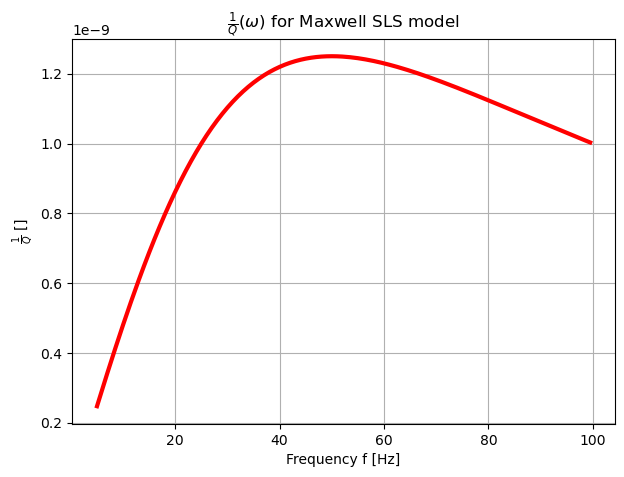

In [10]:
# 1/Q(omega) for the Maxwell SLS
# ------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
omega = 2 * np.pi * f

mu0 = 4e8             # shear modulus (Pa) for soil from Dokter et al. (2017)
mu1 = 1               # shear modulus (Pa)

f1 = 50.0
omega1 = 2 * np.pi * f1

# Define complex shear modulus for Kelvin-Voigt model
# ---------------------------------------------------
muSLSM = mu0 + (1j * mu1 * omega)/((1j * omega) + omega1)

# Calculate 1/Q(omega)
# --------------------
Qinv = np.imag(muSLSM)/np.real(muSLSM)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Qinv, 'r-',lw=3,label="Maxwell SLS model") 
plt.title(r'$\frac{1}{Q}(\omega)$ for Maxwell SLS model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$\frac{1}{Q}$ []')
plt.grid()
plt.show()

这个结果看起来很有希望。虽然 $1/Q$ 与频率无关，但我们看到麦克斯韦SLS模型在给定频率处有一个峰值，在较低和较高的频率处下降。 为了完整起见，我注意到，我们还可以通过并行连接胡克元素和Kelvin-Voigt元素来构建一个 **Kelvin-Voigt SLS模型**。然而，在接下来的文章中，我们将进一步关注麦克斯韦SLS模型的潜力。

## 广义麦克斯韦模型

基于Maxwell SLS模型的良好结果，我们将多个Maxwell模型并行相加，得到**广义Maxwell模型或广义Maxwell体(generalmaxwell body, GMB)**，又称 **Maxwell-wiechert模型**。通过将具有不同弹性模量 $\mu_l$ 和粘度 $\eta_l$ 的多个麦克斯韦模型叠加，我们可以在给定的频率范围内获得恒定的Q值。

<img src="images/GMB.png" width="70%">

因为我们将麦克斯韦SLS模型与额外的L麦克斯韦体并行组装，我们必须在频率域添加应力:

\begin{equation}
\tilde{\sigma}_{GMB} = \tilde{\sigma}_{SLSM} + \sum_{l=2}^{L} \tilde{\sigma}_{Maxwell, l} \notag
\end{equation}

插入应力

\begin{align}
\tilde{\sigma}_{SLSM} &= \biggl(\mu_0 + \frac{i \mu_1 \omega \eta_1}{i \omega \eta_1 + \mu_1}\biggr) \tilde{\epsilon} \notag \\
\tilde{\sigma}_{Maxwell, l} &= \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l} \tilde{\epsilon}\notag \\
\end{align}

给出了GMB的频率域应力-应变关系

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \frac{i \mu_1 \omega \eta_1}{i \omega \eta_1 + \mu_1} + \sum_{l=2}^{L} \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

我们可以把第二项移到L maxwell模型的和中:

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega \eta_l}{i \omega \eta_l + \mu_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

引入 **松弛频率** 

\begin{equation}
\omega_l :=\frac{\mu_1}{\eta_l} \notag
\end{equation}

得到

\begin{equation}
\tilde{\sigma}_{GMB} = \biggl(\mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega}{i \omega + \omega_l}\biggr) \tilde{\epsilon} \notag
\end{equation}

我想化简复模量

\begin{equation}
\tilde{\mu}_{GMB} = \mu_0 + \sum_{l=1}^{L} \frac{i \mu_l \omega}{i \omega + \omega_l}. \notag
\end{equation}

首先我们估计松弛剪切模量:

\begin{equation}
\tilde{\mu}_{GMB,R} = \lim_{\omega\rightarrow 0} \tilde{\mu}_{GMB} = \mu_0\notag
\end{equation}

和非松弛剪切模量:

\begin{equation}
\tilde{\mu}_{GMB,U} = \lim_{\omega\rightarrow \infty} \tilde{\mu}_{GMB} = \mu_0 + \sum_{l=1}^{L} \mu_l\notag
\end{equation}

通过 **模量的缺陷** 或 **模量的松弛** 

\begin{equation}
\delta \mu = \tilde{\mu}_{GMB,U} - \tilde{\mu}_{GMB,R} = \sum_{l=1}^{L} \mu_l\notag
\end{equation}

我们得到

\begin{equation}
\delta \mu_l = \mu_l\notag
\end{equation}

没有任何简化，我们可以考虑

\begin{equation}
\delta \mu_l = a_l \delta \mu\notag
\end{equation}

与标准化

\begin{equation}
\sum_{l=1}^L a_l = 1\notag
\end{equation}

得到 

\begin{equation}
\tilde{\mu}_{GMB} = \mu_0 + \delta \mu \sum_{l=1}^{L} \frac{i a_l \omega}{i \omega + \omega_l}. \notag
\end{equation}

让我们尝试通过使用4个麦克斯韦体并将麦克斯韦体的所有剪切模量设置为一个恒定值，来近似 $Q(\omega) = 10$ 的频率在5到100 Hz之间的模型。

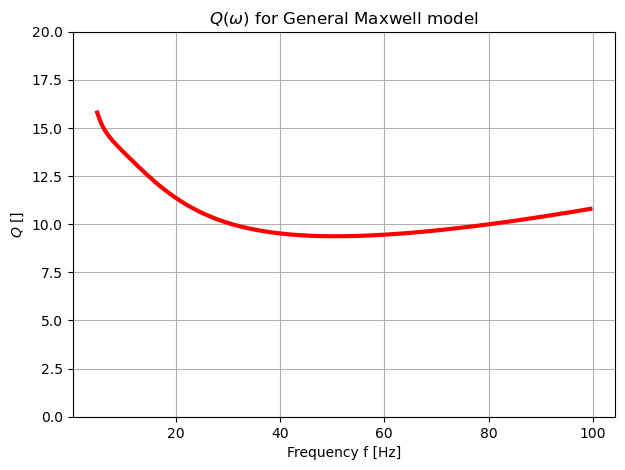

In [11]:
# Q(omega) for the GMB with 4 Maxwell bodies
# --------------------------------------------
f = np.arange(5.0,100.0,0.5)  # frequency (Hz)
nf = len(f)
omega = 2 * np.pi * f

# relaxation frequencies
L = 4   # number of Maxwell bodies
fl = np.linspace(5.0,100.0,L)
omegal = 2. * np.pi * fl

# Define relaxed shear modulus and defect for GMB
mu0 = 4e8          # shear modulus (Pa) for soil from Dokter et al. (2017)
dmu = 1.4e8        # shear moduli of Maxwell bodies (Pa)

# Simply set a_l = 1.0 / L
a_l = 1.0 / L 

# Define complex shear modulus for GMB model
# ------------------------------------------
muM = np.zeros(nf,dtype='complex128')
for l in range(0,L):
    muM += (1j * a_l * omega)/((1j * omega) + omegal[l])
muGMB = mu0 + dmu * muM

# Calculate Q(omega)
# --------------------
Q = np.real(muGMB)/np.imag(muGMB)

# Define figure size
rcParams['figure.figsize'] = 7, 5

# plot stress-strain relation
plt.plot(f, Q, 'r-',lw=3,label="General Maxwell model") 
plt.title(r'$Q(\omega)$ for General Maxwell model')
plt.xlabel('Frequency f [Hz]')
plt.ylabel(r'$Q$ []')
plt.ylim(0,20)
plt.grid()
plt.show()

虽然结果并不完美，但对于频率介于5到100 Hz之间的频率，我们可以得到一个近似恒定的 $Q(\omega)=10$ 值。我们将在下一课中优化这个结果。

## 我们学习到:

- 粘弹性应力-应变关系可以用松弛函数与应变速率的时间卷积来描述。松弛函数和积分界对粘弹性介质施加了因果关系和“衰落”记忆
- 低Q值模型在应力-应变关系中引入了相移。滞回线之间的面积定义了能量损失
- 通过将多个基本胡克和牛顿单元组合在一个串行和/或并行网络中，我们可以在频率域推导出一个复剪切模量，并实现恒定的 $Q(\omega)$ 行为